<a href="https://colab.research.google.com/github/yaelsh66/MLP_Mixer/blob/main/MLP_Mixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm


## MLP Block
This is the MLP implementation of the model.

Consists of:
* FC-layer
* GeLU
* Another FC-layer
* dropout

In [ ]:
# MLP_Block => The MLP implementation of the model
# Consists of: FC-layer -> GeLU -> FC-layer -> dropout

class MLP_Block(nn.Module):
  def __init__(self, num_inputs, num_hidden):
    super(MLP_Block, self).__init__()

    self.mlp = nn.Sequential(
      nn.Linear(num_inputs, num_hidden),
      nn.GELU(),
      nn.Linear(num_hidden, num_inputs),
      nn.Dropout(0.1)
    )

  def forward(self, x):

    return self.mlp(x)



## Mixer Block
This is the implementation of the core block of the model.

Consists of:
* Transpose -> Layer normalization
* Transpose -> token-MLP
* Skip connections (summing the raw input here)
* Layer normalization
* Channel-MLP
* Another skip connections (summing the raw input here too)

In [ ]:
# patch => tokens
# channel => channels
class Mixer_Block(nn.Module):
  def __init__(self, patch_dim, channel_dim, num_patches):
    super(Mixer_Block, self).__init__()
    self.layer_norm1 = nn.LayerNorm(num_patches)
    self.mlp1 = MLP_Block(num_patches, patch_dim)
    self.layer_norm2 = nn.LayerNorm(num_patches)
    self.mlp2 = MLP_Block(num_patches, channel_dim)

  def forward(self, x):
    y = self.layer_norm1(x)
    y = y.transpose(2, 1)
    y = self.mlp1(y)
    y = y.transpose(2, 1)
    y = y + x
    out = self.layer_norm2(y)
    out = self.mlp2(out)
    out = out + y
    return out

## Full Mixer-MLP model
This is the full implementation of the model.

Consists of:
* Sepretaing the input to unoverlapping patches (using convulation but NOT FOR LEANING)
* Transpose -> a loop of {num_patches} Mixer-Blocks
* Global Average Pooling
* One last Normalization layer

In [ ]:
# num_patches = hidden_dim
class MlpMixer(nn.Module):
  def __init__(self, num_patches, patch_size, num_classes, num_blocks, patch_dim, channel_dim):
    super(MlpMixer, self).__init__()

    # Seperating to non-overlapping patches
    self.con = nn.Conv2d(in_channels=3, out_channels=num_patches, kernel_size=patch_size, stride=patch_size)

    self.blocks = nn.ModuleList([Mixer_Block(patch_dim, channel_dim, num_patches) for _ in range(num_blocks)])
    self.layer_norm = nn.LayerNorm(num_patches)
    self.head = nn.Linear(num_patches, num_classes)

  def forward(self, x):
    x = self.con(x)
    x = x.flatten(2).transpose(1, 2)
    for block in self.blocks:
      x = block(x)
    x = x.mean(dim=1)
    x = self.layer_norm(x)

    return self.head(x)




```
# This is formatted as code
```

# Part 2

## Training the Model

### Preprocess dataset
In the preprocess part we included:
* Resizing the images to 256 pixels
* Using Center Crop to adjust the images to 224 X 224
* Normalizing by the means and stds from a viable source
* Adjusting to tensors for NN usage

In [ ]:
# Preprocessing with resize-crop and resmall-crop
def get_transforms(resolution=224, mode='resize-crop'):

  return transforms.Compose([
    transforms.Resize((256, 256)) if mode == 'resize-crop' else transforms.Resize(256),
    transforms.CenterCrop((resolution, resolution)),
    transforms.ToTensor(),
    # RandAugment
    # transforms.RandAugment(num_ops=2, magnitude=15), -> DIDNT HELP
    # Added normalization to get better weights in training
    # from https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2434, 0.2616])
  ])

### Load dataset (CIFAR-10)

In [ ]:

cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=get_transforms(224, 'resmall-crop'))
cifar10_testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=get_transforms(224, 'resmall-crop'))

100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Inspect the dataset
print(f"Number of training samples: {len(cifar10_dataset)}")
print(f"Number of test samples: {len(cifar10_testset)}")
print(f"Shape of one image: {cifar10_testset[0][0].shape} (C x H x W)")
print(f"CIFAR-10 classes: {cifar10_dataset.classes}")

Number of training samples: 50000
Number of test samples: 10000
Shape of one image: torch.Size([3, 224, 224]) (C x H x W)
CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Hyperparameters
We defined the hyperparameters:
* batch_size -> trial & error led us to 64
* learning_rate -> from the paper for pre-train
* weight_decay -> from the paper for pre-train. DIDN'T HELP
* num_epochs -> we wanted 70, settled for 20 :(


In [ ]:

# Hyperparameters
batch_size = 64
cifar_classes = len(cifar10_dataset.classes)
learning_rate = 0.006
num_epochs = 20
weight_decay = 0.01

# Check if we have cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Converting datasets to cuda
train_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=True)

### Here are the parameter specification from the paper:

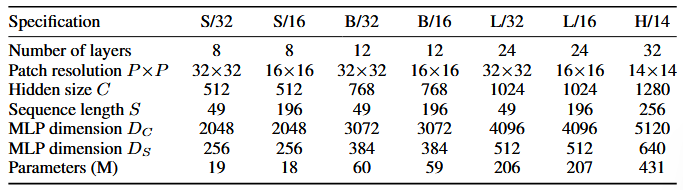

In [ ]:
# Model parameters
# We consider CIFAR-10 as S/32 or B/32

# num_patches
num_patches = 49 # Using the formula from the paper

# Patch resolution
patch_size = 32

# Output size
num_classes = cifar_classes

# Number of Layers
num_blocks_s = 8
num_blocks_b = 12

# MLP dimension D_s (tokens)
patch_dim_s = 256
patch_dim_b = 384

# MLP dimension D_c (channels)
channel_dim_s = 2048
channel_dim_b = 3072

In [ ]:
# Create an instance of the model for S/32
model_S = MlpMixer(
  num_patches=num_patches,
  patch_size=patch_size,
  num_classes=num_classes,
  num_blocks=num_blocks_s,
  patch_dim=patch_dim_s,
  channel_dim=channel_dim_s
  ).to(device)

In [ ]:
# Create an instance of the model for B/32
model_B = MlpMixer(
  num_patches=num_patches,
  patch_size=patch_size,
  num_classes=num_classes,
  num_blocks=num_blocks_b,
  patch_dim=patch_dim_b,
  channel_dim=channel_dim_b
  ).to(device)

### Optimizer with/out weight decey, and loss function

In [ ]:
optimizer_S = torch.optim.Adam(model_S.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)
# optimizer_B = torch.optim.Adam(model_B.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)  # DIDNT HELP
optimizer_B = torch.optim.Adam(model_B.parameters(), lr=learning_rate, betas=(0.9, 0.999))
cost = nn.CrossEntropyLoss()

### Save/Load the model

```
# This is formatted as code
```



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# import os
# save_dir = "/content/drive/My Drive/MixerMLP Models"
# os.makedirs(save_dir, exist_ok=True)


In [ ]:
# model.load_state_dict(torch.load(os.path.join(save_dir, "checkpoint.pth")))
# print(f"Model loaded from {os.path.join(save_dir, 'checkpoint.pth')}")


### Train the model with gradient clipping added to help prevent overfitting.

In [ ]:
# Training function partially implemented for assignment
def train_model(model, loader, optimizer, loss, num_epochs=5):

  model.train() # set model to train
  for epoch in range(num_epochs):

    # create variables to print loss and training accuracy per epoch
    epoch_loss = 0
    total = 0
    correct = 0


    for images, labels in tqdm(loader):
      optimizer.zero_grad()
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)

      loss = cost(outputs, labels)

      loss.backward()

      # # Gradient clipping
      clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()

      # epoch loss and accuracy for printing
      epoch_loss += loss.item()
      _, predicted = model(images).max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    # Printing the loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(loader):.4f}, Accuracy: {100 * correct/total:.2f}%")


In [ ]:
# Ashkara train the model this time
# Patch size 32
# 2.5 mins an epoch
train_model(model_S, train_loader, optimizer_S, cost, num_epochs=30)

 37%|███▋      | 289/782 [00:55<01:34,  5.22it/s]


KeyboardInterrupt: 

In [ ]:
# Patch size B/32
# 3 mins an epoch
train_model(model_B, train_loader, optimizer_B, cost, num_epochs=20)

100%|██████████| 782/782 [02:43<00:00,  4.78it/s]


Epoch [1/20], Loss: 1.1863, Accuracy: 58.92%


100%|██████████| 782/782 [02:43<00:00,  4.78it/s]


Epoch [2/20], Loss: 1.1108, Accuracy: 61.55%


100%|██████████| 782/782 [02:43<00:00,  4.78it/s]


Epoch [3/20], Loss: 1.0585, Accuracy: 63.81%


100%|██████████| 782/782 [02:43<00:00,  4.79it/s]


Epoch [4/20], Loss: 1.0078, Accuracy: 65.64%


100%|██████████| 782/782 [02:44<00:00,  4.76it/s]


Epoch [5/20], Loss: 0.9662, Accuracy: 67.05%


100%|██████████| 782/782 [02:43<00:00,  4.79it/s]


Epoch [6/20], Loss: 0.9271, Accuracy: 68.60%


100%|██████████| 782/782 [02:42<00:00,  4.80it/s]


Epoch [7/20], Loss: 0.8949, Accuracy: 70.05%


100%|██████████| 782/782 [02:43<00:00,  4.80it/s]


Epoch [8/20], Loss: 0.8603, Accuracy: 71.29%


100%|██████████| 782/782 [02:42<00:00,  4.81it/s]


Epoch [9/20], Loss: 0.8268, Accuracy: 72.27%


100%|██████████| 782/782 [02:47<00:00,  4.67it/s]


Epoch [10/20], Loss: 0.7945, Accuracy: 73.57%


100%|██████████| 782/782 [02:48<00:00,  4.65it/s]


Epoch [11/20], Loss: 0.7640, Accuracy: 74.74%


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch [12/20], Loss: 0.7385, Accuracy: 75.61%


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch [13/20], Loss: 0.7041, Accuracy: 76.89%


100%|██████████| 782/782 [02:43<00:00,  4.78it/s]


Epoch [14/20], Loss: 0.6766, Accuracy: 77.72%


100%|██████████| 782/782 [02:43<00:00,  4.79it/s]


Epoch [15/20], Loss: 0.6536, Accuracy: 78.51%


100%|██████████| 782/782 [02:43<00:00,  4.79it/s]


Epoch [16/20], Loss: 0.6281, Accuracy: 79.59%


100%|██████████| 782/782 [02:42<00:00,  4.81it/s]


Epoch [17/20], Loss: 0.5993, Accuracy: 80.35%


100%|██████████| 782/782 [02:42<00:00,  4.80it/s]


Epoch [18/20], Loss: 0.5774, Accuracy: 81.37%


100%|██████████| 782/782 [02:42<00:00,  4.82it/s]


Epoch [19/20], Loss: 0.5513, Accuracy: 82.32%


100%|██████████| 782/782 [02:42<00:00,  4.82it/s]

Epoch [20/20], Loss: 0.5294, Accuracy: 82.99%


# Part 3


### Evaluate the model

In [ ]:
# Evaluation function
def evaluate_model(model, loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Top-1 Test Accuracy: {accuracy:.2f}%")

  return accuracy

In [ ]:
# evaluate your model
print("S/32:")
print("avg runtime per epoch - 02:30")
eval_model_S = evaluate_model(model_S, test_loader)

In [ ]:
print("B/32")
print("avg runtime per epoch - 02:45")
eval_model_B = evaluate_model(model_B, test_loader)

B/32
avg runtime per epoch - 02:45
Top-1 Test Accuracy: 69.24%
